# THE STAR WARS FILMS FRANCHISE
While waiting for the Star Wars VII: The Force Awakens to come out, the team at [FiveThirtyEight](https://fivethirtyeight.com/) collected data through online survey to assess the popularity of each individual film in Star Wars. They published their data on github, which you can download from their [Github](https://github.com/fivethirtyeight/data/tree/master/star-wars-survey) repository.

Based on their data, we will try to determine the most favorite film and character in Star Wars franchise.

## Data Cleaning
We will first try to set up our environment by importing tools that can support us along the way

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid') 
star_wars = pd.read_csv("StarWars.csv", encoding="ISO-8859-1")

In [2]:
star_wars.head(3)

,RespondentID,Have you seen any of the 6 films in the Star Wars franchise?,Do you consider yourself to be a fan of the Star Wars film franchise?,Which of the following Star Wars films have you seen? Please select all that apply.,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Please rank the Star Wars films in order of preference with 1 being your favorite film in the franchise and 6 being your least favorite film.,...,Unnamed: 28,Which character shot first?,Are you familiar with the Expanded Universe?,Do you consider yourself to be a fan of the Expanded Universe?ÅÃ¦,Do you consider yourself to be a fan of the Star Trek franchise?,Gender,Age,Household Income,Education,Location (Census Region)
0,NaN,Response,Response,Star Wars: Episode I The Phantom Menace,Star Wars: Episode II Attack of the Clones,Star Wars: Episode III Revenge of the Sith,Star Wars: Episode IV A New Hope,Star Wars: Episode V The Empire Strikes Back,Star Wars: Episode VI Return of the Jedi,Star Wars: Episode I The Phantom Menace,...,Yoda,Response,Response,Response,Response,Response,Response,Response,Response,Response
1,3.292880e+09,Yes,Yes,Star Wars: Episode I The Phantom Menace,Star Wars: Episode II Attack of the Clones,Star Wars: Episode III Revenge of the Sith,Star Wars: Episode IV A New Hope,Star Wars: Episode V The Empire Strikes Back,Star Wars: Episode VI Return of the Jedi,3,...,Very favorably,I don't understand this question,Yes,No,No,Male,18-29,NaN,High school degree,South Atlantic
2,3.292880e+09,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Yes,Male,18-29,"$0 - $24,999",Bachelor degree,West South Central


Although we haven't checked the entire dataset, it is possible to have other NaN values for RespondentID. We will use the pandas.Series.notnull() method to filter the dataset to contain only rows with valid ID values.

In [3]:
star_wars = star_wars[star_wars['RespondentID'].notnull()]
star_wars.shape

(1186, 38)

## Yes/No Columns
To make our analysis easier, we will convert the columns with Yes or No responses into the bool type by replacing Yes with True and No with False. NaN values will remain as such. bool values make it easier for us to compute aggregate values through methods such as Series.mean() and Series.sum().

Below are the names of the columns that we will perform our value substitution on. We will access them using their indexes to forego typing them.

In [4]:
star_wars.columns[[1,2,30,31,32]]

Index(['Have you seen any of the 6 films in the Star Wars franchise?',
       'Do you consider yourself to be a fan of the Star Wars film franchise?',
       'Are you familiar with the Expanded Universe?',
       'Do you consider yourself to be a fan of the Expanded Universe?ÅÃ¦',
       'Do you consider yourself to be a fan of the Star Trek franchise?'],
      dtype='object')

Let's see first how many Yes / No values each column contains.

In [5]:
for n in [1,2,30,31,32]:
    display(star_wars.iloc[:,n].value_counts(dropna=False))

Yes    936
No     250
Name: Have you seen any of the 6 films in the Star Wars franchise?, dtype: int64

Yes    552
NaN    350
No     284
Name: Do you consider yourself to be a fan of the Star Wars film franchise?, dtype: int64

No     615
NaN    358
Yes    213
Name: Are you familiar with the Expanded Universe?, dtype: int64

NaN    973
No     114
Yes     99
Name: Do you consider yourself to be a fan of the Expanded Universe?ÅÃ¦, dtype: int64

No     641
Yes    427
NaN    118
Name: Do you consider yourself to be a fan of the Star Trek franchise?, dtype: int64

We create a dictionary, yes_no, to contain the substitute values. This dictionary is passed on to the Series.map() method which will take care of the substitution. Note that since NaN is not included, these values will be retained as such. The respondents may have been given the option to not answer the question, hence the missing value.

In [6]:
# Substitute Yes and No values with True and False, respectively
yes_no = {'Yes': True, 'No': False}

for n in [1,2,30,31,32]:
    star_wars.iloc[:,n] = star_wars.iloc[:,n].map(yes_no)

We confirm our changes below. 

In [7]:
for n in [1,2,30,31,32]:
    display(star_wars.iloc[:,n].value_counts(dropna=False))

True     936
False    250
Name: Have you seen any of the 6 films in the Star Wars franchise?, dtype: int64

True     552
True     350
False    284
Name: Do you consider yourself to be a fan of the Star Wars film franchise?, dtype: int64

False    615
True     358
True     213
Name: Are you familiar with the Expanded Universe?, dtype: int64

True     973
False    114
True      99
Name: Do you consider yourself to be a fan of the Expanded Universe?ÅÃ¦, dtype: int64

False    641
True     427
True     118
Name: Do you consider yourself to be a fan of the Star Trek franchise?, dtype: int64

## Checkbox columns
The columns with indexes 3 to 8 of our data set indicate whether a respondent has seen a particular Star Wars film. From the last sentence, "Please select all that apply" (column with index 3), we can deduce that each film title was listed beside a checkbox. If a box was ticked, the corresponding film's title will appear in our dataset. If otherwise, there will be a missing value (NaN), indicating that a respondent has not seen the film.

Similar to the Yes or No columns, we will replace the values with True or False.

Below, the names of the movies are taken from options and stored as a list in movie_names.

In [8]:
import numpy as np

movie_mapping = {
    "Star Wars: Episode I  The Phantom Menace": True,
    np.nan: False,
    "Star Wars: Episode II  Attack of the Clones": True,
    "Star Wars: Episode III  Revenge of the Sith": True,
    "Star Wars: Episode IV  A New Hope": True,
    "Star Wars: Episode V The Empire Strikes Back": True,
    "Star Wars: Episode VI Return of the Jedi": True
}

for col in star_wars.columns[3:9]:
    star_wars[col] = star_wars[col].map(movie_mapping)

In [9]:
seen = {
  'Which of the following Star Wars films have you seen? Please select all that apply.': 'seen1',
  'Unnamed: 4': 'seen2',
  'Unnamed: 5': 'seen3',
  'Unnamed: 6': 'seen4',
  'Unnamed: 7': 'seen5',
  'Unnamed: 8': 'seen6'
}
star_wars.rename(columns=seen, inplace=True)
star_wars[star_wars.columns[3:9]].head()

,seen1,seen2,seen3,seen4,seen5,seen6
1,True,True,True,True,True,True
2,False,False,False,False,False,False
3,True,True,True,False,False,False
4,True,True,True,True,True,True
5,True,True,True,True,True,True


## Ranking Columns
The next six columns after the checkbox columns let the respondent rank the movies according to preference. Since there are six movies, each movie is ranked on a scale of 1-6, with 1 being the highest.

We see that each column is of the type, object.

We will convert them to a numeric type and then rename the columns to something more intuitive like we did with the checkbox columns.

In [10]:
star_wars[star_wars.columns[9:15]] = star_wars[star_wars.columns[9:15]].astype(float)

In [11]:
star_wars[star_wars.columns[9:15]].head()

,Please rank the Star Wars films in order of preference with 1 being your favorite film in the franchise and 6 being your least favorite film.,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
1,3.0,2.0,1.0,4.0,5.0,6.0
2,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,2.0,3.0,4.0,5.0,6.0
4,5.0,6.0,1.0,2.0,4.0,3.0
5,5.0,4.0,6.0,2.0,1.0,3.0


As with the checkbox columns, we conduct a similar process of creating a dictionary and using the DataFrame.rename() method to replace the ranking column names.

In [12]:
ranking = {
  'Please rank the Star Wars films in order of preference with 1 being your favorite film in the franchise and 6 being your least favorite film.': 'ranking_1',
  'Unnamed: 10': 'ranking_2',
  'Unnamed: 11': 'ranking_3',
  'Unnamed: 12': 'ranking_4',
  'Unnamed: 13': 'ranking_5',
  'Unnamed: 14': 'ranking_6'
}
star_wars.rename(columns=ranking, inplace=True)
star_wars[star_wars.columns[9:15]].head()


,ranking_1,ranking_2,ranking_3,ranking_4,ranking_5,ranking_6
1,3.0,2.0,1.0,4.0,5.0,6.0
2,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,2.0,3.0,4.0,5.0,6.0
4,5.0,6.0,1.0,2.0,4.0,3.0
5,5.0,4.0,6.0,2.0,1.0,3.0


In [13]:
star_wars[star_wars.columns[9:15]].mean()

ranking_1    3.732934
ranking_2    4.087321
ranking_3    4.341317
ranking_4    3.272727
ranking_5    2.513158
ranking_6    3.047847
dtype: float64

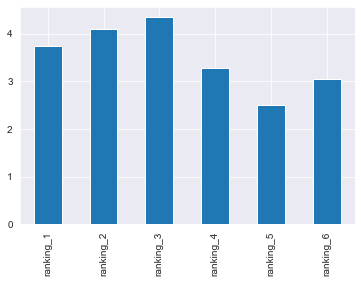

In [14]:
star_wars[star_wars.columns[9:15]].mean().plot(kind='bar')
plt.show()

### Rankings
So far, we've cleaned up the data, renamed several columns, and computed the average ranking of each movie. As I suspected, it looks like the "original" movies are rated much more highly than the newer ones.

In [15]:
star_wars[star_wars.columns[3:9]].sum()

seen1    673
seen2    571
seen3    550
seen4    607
seen5    758
seen6    738
dtype: int64

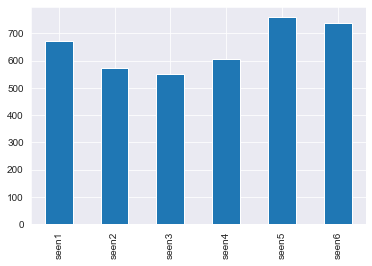

In [16]:
star_wars[star_wars.columns[3:9]].sum().plot(kind='bar')
plt.show()

The bar chart above shows the total number of views of each Star Wars series.

Comparing 2 bar charts, we can conclude that the greater the number of views, the greater the ranking is.

In [17]:
males = star_wars[star_wars['Gender'] == 'Male']
females = star_wars[star_wars['Gender'] == 'Female']

In [18]:
ranking_sex = pd.DataFrame({'males': males[males.columns[9:15]].mean(),
                            'females': females[females.columns[9:15]].mean()})
ranking_sex

,males,females
ranking_1,4.037825,3.429293
ranking_2,4.224586,3.954660
ranking_3,4.274882,4.418136
ranking_4,2.997636,3.544081
ranking_5,2.458629,2.569270
ranking_6,3.002364,3.078086


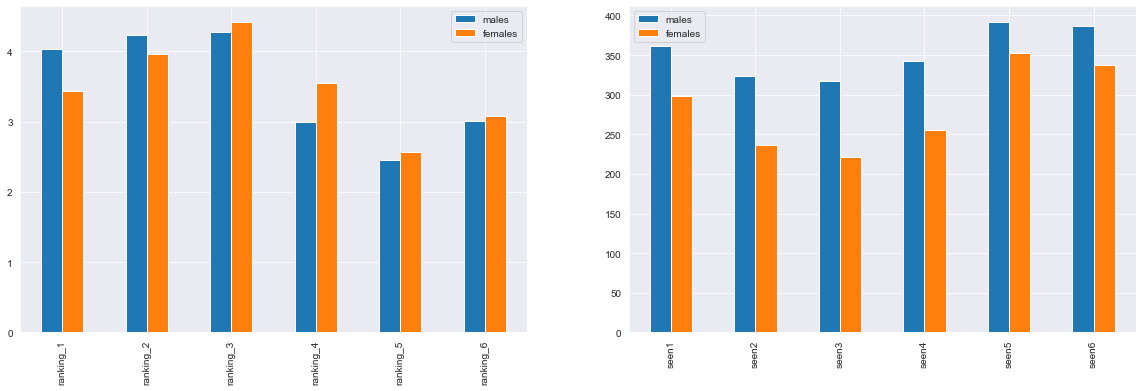

In [19]:
seen_sex = pd.DataFrame({'males': males[males.columns[3:9]].sum(),
                         'females': females[females.columns[3:9]].sum()})
fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ranking_sex.plot(kind='bar', ax=ax1)
seen_sex.plot(kind='bar', ax=ax2)
plt.show()

The above 2 bar charts shows the rankings and number of views segmented by genders.

In conclusion, males preferences as shown by the rankings are slightly extreme than females.

In addition, males tend to love to watch Star Wars more than females, unaffected by preferences.